## Workbook of tonal harmony
#### Analysis of the chorale BWV253 from the JS Bach's corpus in music21

In [1]:
from pcsPy import *
import pickle, copy
from IPython.display import Image 

<IPython.core.display.Javascript object>

Here we import the tonal model we are going to use for the analysis. A tonal model is the matrix of all the operators that connect the chords of a chord library as roman numerals.
Typical models are built using combinations of basic chord symbols and possible extension. 

Use tonalHarmonyModel.py to generate or modify models

In [130]:
f = open('../tonal.harmony.minimal','rb')
head = pickle.load(f)
table = pickle.load(f)
f.close()
tab = np.array(table)

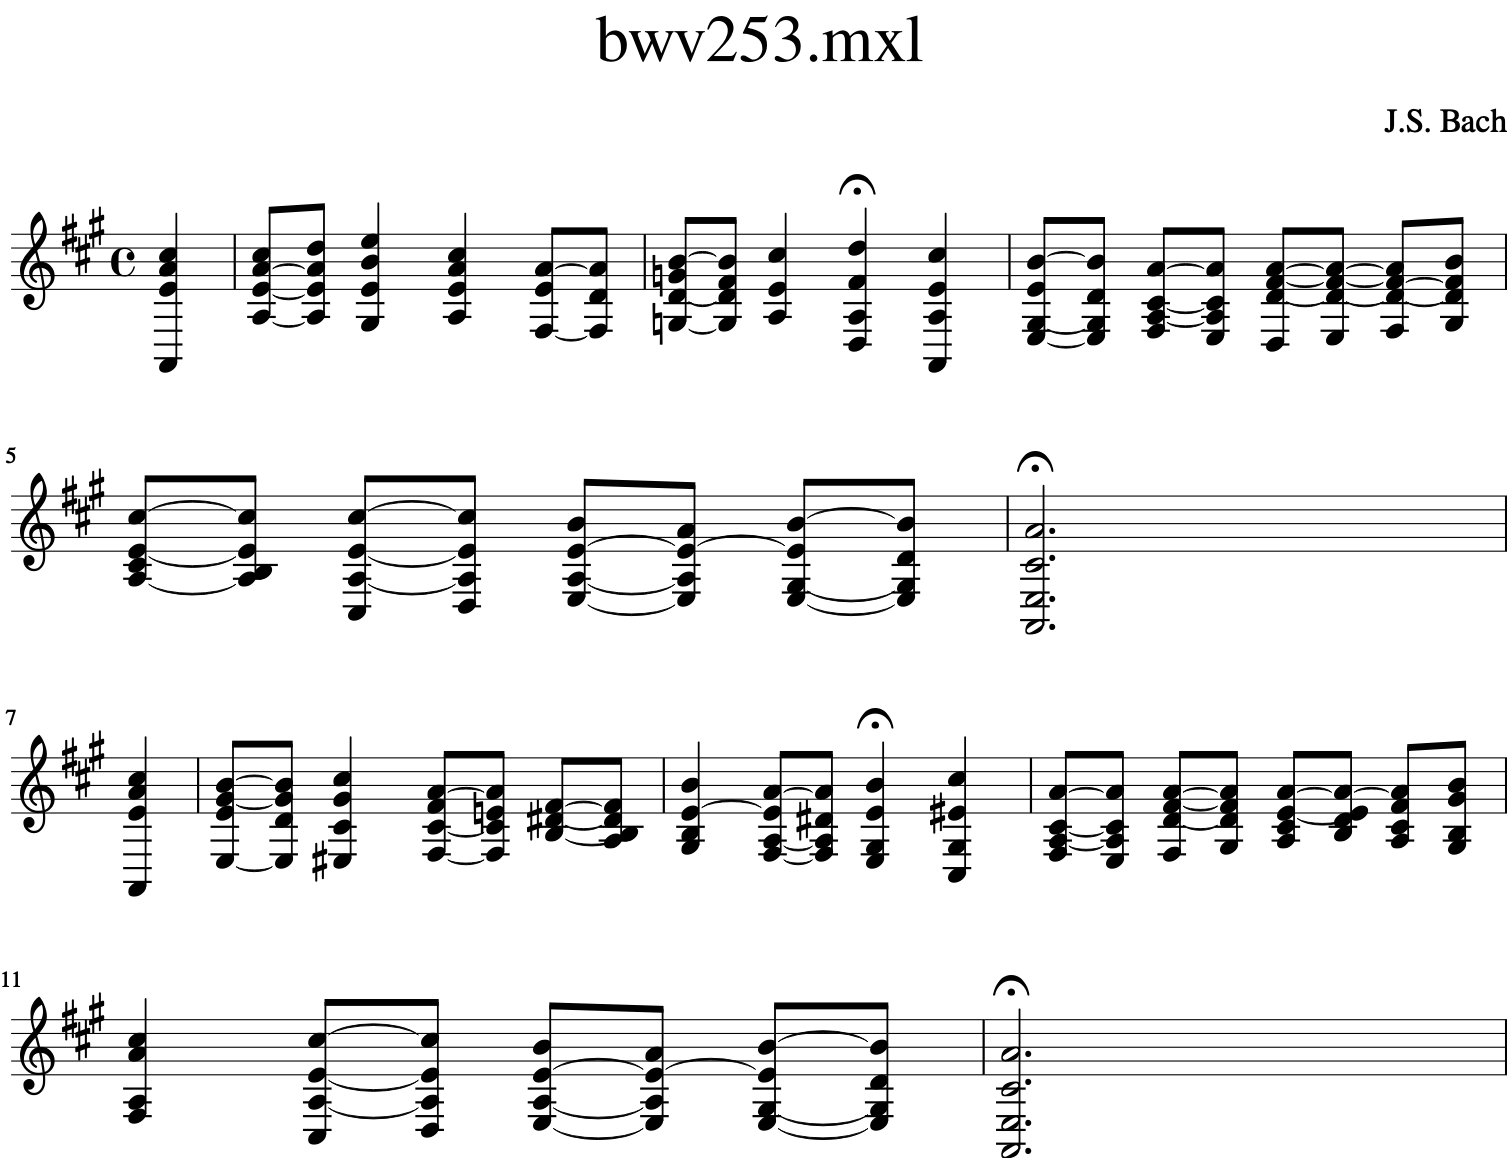

In [3]:
bachChorale = m21.corpus.parse('bwv253').corpusFilepath
seq,chords = readScore(bachChorale,music21=True,show=True)

In [ ]:
# To write chords and corresponding operators - uses musescore
WRITEscoreOps(seq,w=True)

In [199]:
# subtract non-harmonic passing notes from chord for easier interpretation
# seq[60] = [2,5,9]

In [4]:
dnodes,dedges,dcounts,deg,modul,Gx,Gxu = scoreNetwork(seq,ntx=True,general=True)
print('average degree = ',deg,' modularity = ',modul)
# Write to csv for visualization in Gephi or other network drawing software (see figure below)
# dnodes.to_csv('nodesbwv66.csv')
# dedges.to_csv('edgesbwv66.csv')
# Get modularity scores
part = cm.best_partition(Gxu) #,resolution=0.4)

average degree =  1.7826086956521738  modularity =  0.375


## ![title]()

In [5]:
dn = np.array(dnodes)
labe = []
modu = []
modul = []
for m in range(len(dn)):
    labe.append(str(dn[m][0]))
    modu.append(part[str(m)])
    modul.append([str(dn[m][0]),Gx.degree()[str(m)],part[str(m)]])
modul = pd.DataFrame(modul,columns=['Label','Degree','Modularity'])
moduldict = dict(zip(labe,modu))

In [138]:
# display the score with modularity classes
mc = []
for n in range(len(seq)):
    p = PCSet(np.asarray(seq[n]))
    nn = ''.join(m21.chord.Chord(p.normalOrder().tolist()).pitchNames)
    mc.append(''.join(m21.chord.Chord(p.normalOrder().tolist()).pitchNames))

In [139]:
l = 0
analyzed = copy.deepcopy(chords)
for c in analyzed.recurse().getElementsByClass('Chord'):
    c.closedPosition(forceOctave=4,inPlace=True)
    c.addLyric(str(l))
    c.addLyric(moduldict[mc[l]])
    l += 1
analyzed.show('musicxml')

In [92]:
modul[['Label','Degree','Modularity']].query('Modularity == 1').sort_values(by=['Degree'],ascending=False)

,Label,Degree,Modularity
16,EG#B,9,1
15,EF#A,4,1
8,DEA,2,1
12,E-F#A,2,1


In [98]:
# Dictionary of modularity classes and relative keys
keydict = {0:'A', 1:'E', 2:'A', 3:'A', 4:'B'}

In [182]:
# moduldict['B-CE'] = 2
# moduldict['C#EG'] = 3
# print(moduldict)

In [177]:
# Dictionary of nomenclature for notes in music21 Chords
idx = []
notes = []
for n in range(60,84):
    no = m21.note.Note(n).nameWithOctave
#     if no == 'G#4': no = 'A-4'
#     if no == 'G#5': no = 'A-5'
    if no == 'A#4': no = 'B-4'
    if no == 'A#5': no = 'B-5'
    if no == 'E-4': no = 'D#4'
    if no == 'E-5': no = 'D#5'
    notes.append(no)
    idx.append(n)
notedict = dict(zip(idx, notes))

In [15]:
# Determination of operators
try:
    ntot = seq.shape[0]
except:
    ntot = len(seq)
ops = []
for i in range(ntot):
    if i < ntot-1: 
        ops.append(generalizedOpsName(seq[i],seq[i+1])[1])

In [195]:
# Score analysis
verbose = False
# First chord
rn = []
ch = np.copy(seq[0])
for n in range(1,len(ch)):
    if ch[n] < ch[n-1]: ch[n] += 12
ch += 60
n = m21.chord.Chord(ch.tolist())
chord = ''.join(n.pitchNames)
key = keydict[moduldict[chord]] 
rn.append(m21.roman.romanNumeralFromChord(n, m21.key.Key(key)).figure)
# Full score
nx = ntot-1
i = 0
check = 0
while i < nx:   
    try:
        if i == 3600:
            rn.append('')
        elif i == 4200:
            rn.append('')
        else:
            idx,idy = np.where(tab == ops[i])
            tmp = []
            for n in range(len(idy)):
                if (rn[i] == str(head[idx[n]])):
                    tmp.append(head[idy[n]])
            if len(tmp) == 1:
                rn.append(tmp[0])
            else:
                chord = ''.join(m21.chord.Chord(PCSet(seq[i]).normalOrder().tolist()).pitchNames)
                key = keydict[moduldict[chord]]
                for n in range(len(tmp)):
                    ch = m21.roman.RomanNumeral(tmp[n],m21.key.Key(key)).pitchClasses
                    if PCSet(ch).normalOrder().tolist() == seq[i+1]:
                        rn.append(str(tmp[n]))
                        break
        i += 1
    except:
        try:
            if check == i:
                break
            else:
                print('modulation at or before chord no. ',i)
                check = i
                rn.pop()
                ch = np.copy(PCSet(seq[i-1]).normalOrder().tolist())
                for n in range(1,len(ch)):
                    if ch[n] < ch[n-1]: ch[n] += 12
                ch += 60
                p = []
                for c in ch:
                    p.append(notedict[c])
                n = m21.chord.Chord(p)
                
                chord = ''.join(n.pitchNames)
                m = m21.chord.Chord(ch.tolist())
                if verbose: print(n.chordTablesAddress,n,keydict[moduldict[''.join(m.pitchNames)]] )
                try:
                    key = keydict[moduldict[''.join(m.pitchNames)]] 
                    rn.append(m21.roman.romanNumeralFromChord(n, m21.key.Key(key)).figure)
                    if rn[i-1] == 'V65': rn[i-1] = 'V7'
                    if rn[i-1] == 'V42': rn[i-1] = 'V7'
                    if rn[i-1] == 'II65': rn[i-1] = 'II7'
                    if rn[i-1] == 'ii42': rn[i-1] = 'ii7[no5]'
                    i -= 1
                except Exception as e:
                    print(type(e))
                    print(e.args)
                    print(e) 
                    print(chord)
                    break
        except Exception as e:
            print(type(e)) 
            break
nx = i

modulation at or before chord no.  39
modulation at or before chord no.  46


In [162]:
ch = np.copy(PCSet(seq[38]).normalOrder().tolist())
for n in range(1,len(ch)):
    if ch[n] < ch[n-1]: ch[n] += 12
ch += 60
print(ch)
p = []
for c in ch:
    p.append(notedict[c])
print(p)
n = m21.chord.Chord(['E4', 'F#4', 'A4'])
print(n.chordTablesAddress)
print(n)
print(m21.roman.romanNumeralFromChord(n, m21.key.Key('E')).figure)

[64 66 69]
['E4', 'F#4', 'A4']
ChordTableAddress(cardinality=3, forteClass=7, inversion=1, pcOriginal=4)
<music21.chord.Chord E4 F#4 A4>
ii42


In [163]:
n = m21.chord.Chord(['E4', 'F#4', 'A4'])
m21.roman.postFigureFromChordAndKey(n, m21.key.Key('E'))

'42'

In [167]:
m21.roman.RomanNumeral('ii7[no5]','E').pitches

(<music21.pitch.Pitch F#4>, <music21.pitch.Pitch A4>, <music21.pitch.Pitch E5>)

In [ ]:
# Score analysis
# First chord
rn = []
ch = np.copy(seq[0])
for n in range(1,len(ch)):
    if ch[n] < ch[n-1]: ch[n] += 12
ch += 60
n = m21.chord.Chord(ch.tolist())
chord = ''.join(n.pitchNames)
key = keydict[moduldict[chord]] 
rn.append(m21.roman.romanNumeralFromChord(n, m21.key.Key(key)).figure)
# Full score
nx = ntot-1
for i in range(nx):
    try:
        # these are the modulations
        if i == 4:
            rn.append('i')
        elif i == 5:
            rn.append('I')
        elif i == 10:
            rn.append('I')
        elif i == 11:
            rn.append('viio7')
        elif i == 17:
            rn.append('i')
        else:
            idx,idy = np.where(tab == ops[i])
            tmp = []
            for n in range(len(idy)):
                if (rn[i] == str(head[idx[n]])):
                    tmp.append(head[idy[n]])
            if len(tmp) == 1:
                rn.append(tmp[0])
            else:
                chord = ''.join(m21.chord.Chord(PCSet(seq[i]).normalOrder().tolist()).pitchNames)
                key = keydict[moduldict[chord]]
                for n in range(len(tmp)):
                    ch = m21.roman.RomanNumeral(tmp[n],m21.key.Key(key)).pitchClasses
                    if PCSet(ch).normalOrder().tolist() == seq[i+1]:
                        rn.append(str(tmp[n]))
                        break
    except Exception as e:
        print('check at or before chord no. ',i,' for possible modulation')
        print(type(e),e)
        nx = i
        break

In [204]:
# Create dictionary of score analysis
reference = []
for n in range(nx):
    try:
        chord = ''.join(m21.chord.Chord(PCSet(seq[n]).normalOrder().tolist()).pitchNames)
        entry = [PCSet(seq[n]).normalOrder(),chord,rn[n],ops[n],keydict[moduldict[chord]],moduldict[chord]]
        reference.append(entry)
    except:
        pass

In [205]:
# Add last chord
ops.append(' ')
chord = ''.join(m21.chord.Chord(PCSet(seq[nx]).normalOrder().tolist()).pitchNames)
entry = [PCSet(seq[nx]).normalOrder(),chord,rn[nx],ops[nx],keydict[moduldict[chord]],moduldict[chord]]
reference.append(entry)

In [206]:
# Set dictionary as pandas dataframe
analysis = pd.DataFrame(reference,columns=['pcs','chord','rn','ops','key','modul'])

In [207]:
analysis

,pcs,chord,rn,ops,key,modul
0,"[9, 1, 4]",AC#E,I,"O(0,0,0)",A,0
1,"[9, 1, 4]",AC#E,I,"O(0,1,0)",A,0
2,"[2, 4, 9]",DEA,iv52,"O(-3,0,-1)",E,1
3,"[4, 8, 11]",EG#B,V,"O(0,1,2)",E,1
4,"[9, 1, 4]",AC#E,I,"O(0,3,2)",A,0
5,"[4, 6, 9]",EF#A,vi7[no5],"O(-2,0,0)",E,1
6,"[2, 6, 9]",DF#A,IV,"O(0,1,2)",A,0
7,"[7, 11, 2]",GBD,bVII,"O(0,0,0,-1)",A,0
8,"[6, 7, 11, 2]",F#GBD,bVII#7,"O(-2,2,-2,-1)",A,0
9,"[9, 1, 4]",AC#E,I,"O(0,1,2)",A,0


In [137]:
analysis.to_csv('bwv253.csv')

In [240]:
# display the analyzed score
l = 0
analyzed = copy.deepcopy(chords)
for c in analyzed.recurse().getElementsByClass('Chord'):
    c.addLyric('')
    c.addLyric('')
    c.addLyric(str(ops[l]))
    c.addLyric(str(rn[l]))
    l += 1
analyzed.show('musicxml')

In [119]:
seq[44],ops[44],seq[45]

([2, 6, 9], 'O(0,0,0,-1)', [2, 6, 8, 9])

In [80]:
seq[24],ops[25],seq[25]

([9, 11, 4], 'O(2,0,-1)', [4, 9])